In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.random_projection import GaussianRandomProjection
from tqdm import tqdm
import sys
import math

sys.path.append('../')
sys.path.append('../src/')

from src.utils import set_plotting_params
from src.detection import DataCopyingDetector, ThreeSampleDetector
from src.generative import * 

# Failure Cases

## Meehan

In [2]:
S = Halfmoons(noise=0.1).sample(2000)
P = Halfmoons(noise=0.1).sample(1000)

copying = Memorizer(radius=0.02, n_copying=20)
underfit = Memorizer(radius=0.25, n_copying=len(S))
rhos = np.round(np.linspace(0, 1, 11), 2)
num_regions_hf = [5, 10, 20]
n_trials = 20

In [ ]:
# C_S_hf = np.zeros((len(rhos), len(num_regions_hf), n_trials))

# for i, r in enumerate(tqdm(rhos)):
#     q = Mixture(rho=r, q1=copying, q2=underfit).fit(S)
#     for j, c in enumerate(num_regions_hf):
#         tst = ThreeSampleDetector(num_regions=c)
#         for t in range(n_trials):
#             C_S_hf[i, j, t] = tst.C_T(Q=q, X_train=S, X_test=P)[0]


# np.save('../doc/Limitations/C_S_hf.npy', C_S_hf)

In [4]:
mnist = MNIST(root='../data.nosync/').fit()
S = mnist.sample()
P = mnist.sample(10000, S="val")

copier = Memorizer(radius=0.05, n_copying=20)
underfit = Memorizer(radius=0.5, n_copying=len(S))
rhos = np.round(np.linspace(0, 1, 11), 2)
num_regions_mnist = [25, 50, 75]
n_trials = 20

In [ ]:
# C_S_mnist = np.zeros((len(rhos), len(num_regions_mnist), n_trials))

# for i, r in enumerate(tqdm(rhos)):
#     q = Mixture(rho=r, q1=copier, q2=underfit).fit(S)
#     for j, c in enumerate(num_regions_mnist):
#         tst = ThreeSampleDetector(num_regions=c)
#         for t in range(n_trials):
#             C_S_mnist[i, j, t] = tst.C_T(Q=q, X_train=S, X_test=P)[0]

# np.save('../doc/Limitations/C_S_mnist.npy', C_S_mnist)

In [6]:
# visualize q 
X = Halfmoons(noise=0.1).sample(20)
copier = Memorizer(radius=0.05, n_copying=3)
underfit = Memorizer(radius=0.25, n_copying=len(X))
q = Mixture(rho=0.5, q1=copier, q2=underfit).fit(X)
X_subset = q.q1.subset
X_gen = q.sample(50)

In [7]:
### plotting
textwidth = set_plotting_params()
line_styles = ['--', '-.', ':']
colors = sns.color_palette('colorblind')
markers = ['.', 'x', '^', 'h', '^', 'v', '>', '<', 'p', '*', 'h']
markersize = [5, 4, 3, 2, 1]

C_S_hf = np.load('../doc/Limitations/C_S_hf.npy')
C_S_mnist = np.load('../doc/Limitations/C_S_mnist.npy')

fig, axs = plt.subplots(1, 3, figsize=(textwidth, 2))
axs_model = axs[0]

# model
axs_model.scatter(X_gen[:, 0], X_gen[:, 1], color=colors[1], marker='x', label='T', alpha=0.7, s=5)
axs_model.scatter(X[:, 0], X[:, 1], color=colors[0], marker='o', label='S', s=5, alpha=0.7)
# axs_model.scatter(X_subset[:, 0], X_subset[:, 1], color=colors[0], s=10, marker='x')
# draw circles around copied points (radius = 0.1)
for x in X_subset:
    circle = plt.Circle(x, 0.15, color='black', fill=False)
    axs_model.add_artist(circle)
axs_model.legend()
axs_model.set_title("(a) Mixed Model")
axs_model.set_xticks([])
axs_model.set_yticks([])

# results
axs_results = [axs[1], axs[2]]
for i, (C_S, ax, num_regions) in enumerate(zip([C_S_hf, C_S_mnist], axs_results, [num_regions_hf, num_regions_mnist])):
    # for j, c in enumerate(num_regions):
    mean = np.mean(C_S[:, 0, :], axis=1)
    std = np.std(C_S[:, 0, :], axis=1)
    ax.plot(rhos, mean,
            # label=f"{c}", 
            linestyle=line_styles[0],
            color=colors[3],
            marker=markers[0],
            markersize=markersize[0],
    )
    ax.fill_between(rhos, mean - std, mean + std, alpha=0.2, color=colors[3])

    ax.axhline(-3, color='black', linestyle='-')
    ax.set_xlabel("$\\rho$")
    ax.set_ylabel("$C_S$")
    ax.set_title("(b) Halfmoons (2D)" if i == 0 else "(c) MNIST (64D)")
    # make x and y ticks at 0, 0.2, ..., 1
    ax.set_xticks(np.linspace(0, 1, 6))

# axs[1].legend(fontsize='6', title='Number of regions', title_fontsize='6', loc='upper right')
# axs[2].legend(fontsize='6', title='Number of regions', title_fontsize='6', loc='lower left')

plt.tight_layout()
plt.savefig('../doc/Limitations/C_S_2.png', dpi=300)
plt.close()

## Bhattacharjee

### 1 Example

In [14]:
lambda_value = 2.5  # Set the value of lambda
x1 = np.linspace(0, 1, 1000)  # Range for Uniform(0, 1)
x2 = np.linspace(0, 1/lambda_value, 1000)  # Range for Uniform(0, 1/lambda)

textwidth = set_plotting_params()
colors = sns.color_palette('colorblind')
plt.figure(figsize=(0.7*textwidth, 2))

plt.fill_between(x1, 1, alpha=0.5, label=r'Uniform(0, 1)', color=colors[0])
plt.fill_between(x2, lambda_value, alpha=0.5, label=r'Uniform(0, $\frac{1}{\lambda}$)', color=colors[1])

plt.xticks([0, 1/lambda_value, 1], [r'0', r'$\frac{1}{\lambda}$', r'1'])
plt.yticks([0, 1, lambda_value], [r'0', r'1', r'$\lambda$'])

plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend()

plt.grid(True)
plt.tight_layout(pad=0.5)
plt.savefig('../doc/Limitations/underfitted_uniform.png', dpi=300)
plt.close()

### 2 Example

In [25]:
S = np.random.uniform(0, 1, (10, 2))
q = SphereSurfaceCopier(radius=0.05).fit(S)
T = q.sample(100)

Radius depends on $n$, $\lambda$, and $d$.

In [20]:
n = 4000
lmbdas = [5, 10, 20]
dims_plot = np.arange(1, 31, 1)
rhos = np.round(np.linspace(0.1, 1, 10), 2)
print(rhos)
r_star = np.zeros((len(dims_plot), len(lmbdas), len(rhos)))

for l, r in enumerate(rhos):
    for j, lmbda in enumerate(lmbdas):
        for i, d in enumerate(dims_plot):
            r_star[i, j, l] = (math.gamma(d/2 + 1) / (np.pi ** (d/2) * lmbda * 20 * r)) ** (1/d)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [25]:
n_r = 50
dims = np.arange(1, 6, 1)
crs = np.zeros((len(dims), n_r))
print(f"radius rho=0.4, lambda=20, dim=1:" , r_star[2, 2, 4])
radii = np.logspace(-5, 0, n_r)

for i, d in enumerate(tqdm(dims)):
    X = np.random.uniform(0, 1, (n, d))
    for j, r in enumerate(radii):
        q = Mixture(rho=0.4, q1=Memorizer(radius=r), q2=Memorizer(radius=0.5, n_copying=len(X))).fit(X)
        det = DataCopyingDetector(lmbda=20)
        crs[i, j] = det.estimate_cr(X, q, m=int(1e6))
    

radius rho=0.4, lambda=20, dim=1: 0.10607844179470553


100%|██████████| 5/5 [06:09<00:00, 73.90s/it]


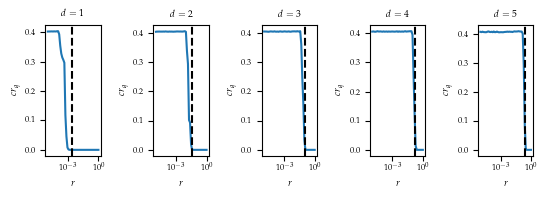

In [24]:
# plot
fig, axs = plt.subplots(1, 5, figsize=(textwidth, 2))

for i, ax in enumerate(axs):
    ax.plot(radii, crs[i, :], label=f"$d = {dims[i]}$")
    # plot theoretical r_star as vertical line
    ax.axvline(r_star[i, 2, 4], color='black', linestyle='--')
    ax.set_xscale('log')

    ax.set_xlabel("$r$")
    ax.set_ylabel("$cr_q$")
    ax.set_title(f"$d = {dims[i]}$")

plt.tight_layout()

In [19]:
n_r = 50
dims = np.arange(1, 6, 1)
crs = np.zeros((len(dims), n_r))
powers = [-6, -4, -3, -2, -2]
rs = np.array([np.logspace(p, p+2, n_r) for p in powers])

for i, d in enumerate(tqdm(dims)):
    X = np.random.uniform(0, 1, (n, d))
    for j, radius in enumerate(rs[i]):
        q = SphereSurfaceCopier(radius=radius).fit(X)
        det = DataCopyingDetector(lmbda=lmbda)
        crs[i, j] = det.estimate_cr(X, q, m=int(1e5))

100%|██████████| 5/5 [01:26<00:00, 17.21s/it]


In [31]:
textwidth = set_plotting_params()

fig = plt.figure(figsize=(textwidth, 4))

gs = gridspec.GridSpec(2, 10, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, :5])  
ax2 = fig.add_subplot(gs[0, 5:])
ax3 = fig.add_subplot(gs[1, 0:2]) 
ax4 = fig.add_subplot(gs[1, 2:4], sharey=ax3)  # Share y-axis with ax3
ax5 = fig.add_subplot(gs[1, 4:6], sharey=ax3)  # Share y-axis with ax3
ax6 = fig.add_subplot(gs[1, 6:8], sharey=ax3)  # Share y-axis with ax3
ax7 = fig.add_subplot(gs[1, 8:10], sharey=ax3) # Share y-axis with ax3

# Turn off y-axis labels but keep ticks visible for ax4 to ax7
for ax in [ax4, ax5, ax6, ax7]:
    plt.setp(ax.get_yticklabels(), visible=False)

# ax1: show model
ax1.scatter(S[:, 0], S[:, 1], s=10, alpha=0.7, label='S', marker='o')
ax1.scatter(T[:, 0], T[:, 1], s=10, alpha=0.7, label='T', marker='x')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.legend(loc='lower right')
ax1.title.set_text('(a) SphereSurfaceCopier')

# ax2: theoretical radius
ax2.plot(dims_plot, r_star[:, 0], 's--', label=f'$\\lambda n ={5*n}$', color='lightgrey')
ax2.plot(dims_plot, r_star[:, 1], '^--', label=f'$\\lambda n ={10*n}$', color='grey')
ax2.plot(dims_plot, r_star[:, 2], '.--', label=f'$\\lambda n ={20*n}$', color='black')
ax2.set_xlabel('d')
ax2.set_ylabel('$r$')
ax2.set_yscale('log')
ax2.set_xticks([1, 5, 10, 15, 20, 25, 30])
ax2.legend(loc='lower right')
ax2.title.set_text('(b) $r = (\\frac{\\Gamma(d/2 + 1)}{\\pi^{d/2} \\lambda n})^{1/d}$')

# ax3-7: show CR with theoretical r_star
for i, d in enumerate(dims):
    ax = eval(f'ax{i+3}')
    ax.plot(rs[i], crs[i])
    ax.set_xscale('log')
    ax.axvline(x=r_star[i, 2], color='black', linestyle='--')
    ax.title.set_text(f'({chr(99+i)}) d={d}')
    ax.set_xlabel('r\'')

ax3.set_ylabel('$cr_q$')


plt.tight_layout(pad=0.3)
plt.savefig('../doc/Limitations/theory_radius.png', dpi=300)
plt.close()

In [10]:
### TODO: Do this somewhere else... 

# dim = 10 
# d_proj = [1, 2, 3, 4]
# k = 5
# m = int(1e5)
# X = np.random.uniform(0, 1, (n, dim))

# crs = np.zeros((len(d_proj), n_r))
# rs = np.array([np.linspace(0, r_star[i]*3, n_r) for i in range(len(d_proj))])

# for i, d in enumerate(tqdm(d_proj)):
#     for j, radius in enumerate(rs[i]):
#         q = SphereSurfaceCopier(radius=radius).fit(X)
#         X1_gen = q.sample(m)
#         X2_gen = q.sample(m)
#         det = DataCopyingDetector(lmbda=lmbda)
#         results = np.zeros((m, k)).astype(bool)
#         for l in range(k):
#             rp = GaussianRandomProjection(n_components=d).fit(X)
#             X_rp = rp.transform(X)
#             X1_gen_rp = rp.transform(X1_gen)
#             X2_gen_rp = rp.transform(X2_gen)
#             idx = det.get_copying_indices(X_rp, X1_gen_rp, X2_gen_rp)
#             results[idx, l] = True
#         crs[i, j] = (results.mean(axis=1) > 0.5).mean()
        
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# for i, d in enumerate(d_proj):
#     ax = axs[i]
#     ax.plot(rs[i], crs[i])
#     ax.axvline(x=r_star[d-1], color='r', linestyle='--')
#     ax.set_title(f"d_proj={d}")
#     ax.set_xlabel('r')
#     ax.set_ylabel('CR')